In [1]:
import os

import shapely

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage


In [2]:
# open & load downloaded file, print its type
with open('static/Minneapolis_Neighborhoods.geojson') as json_data:
    minneapolis_data = json.load(json_data)
type(minneapolis_data)

dict

In [3]:
print ("minneapolis_data key and value's length are: ") 
for key, value in minneapolis_data.items(): 
    print (key, len(str(value)))

minneapolis_data key and value's length are: 
type 17
features 784568


In [4]:
neighborhoods_data = minneapolis_data['features']
pprint(neighborhoods_data[0])

{'geometry': {'coordinates': [[[-93.2625807586419, 44.9609082137146],
                               [-93.2651164994596, 44.9609127449416],
                               [-93.2651165640952, 44.9609127450086],
                               [-93.2664062114491, 44.9609052071166],
                               [-93.266417352931, 44.9609051825404],
                               [-93.2676540485292, 44.9609024334108],
                               [-93.2676870889584, 44.960902359824],
                               [-93.2682869339451, 44.9609043797482],
                               [-93.2688786653363, 44.9609063703855],
                               [-93.2689672106748, 44.9609066679167],
                               [-93.2689749821239, 44.9609066937013],
                               [-93.2689750366206, 44.9609066937559],
                               [-93.2691995917041, 44.9609039915204],
                               [-93.2695462326852, 44.960899817998],
                       

In [5]:
column_names = ['Neighborhood', 'Latitude','Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Neighborhood,Latitude,Longitude


In [6]:
for data in neighborhoods_data:
    neighborhood_name = data['properties']['BDNAME']
    neighborhood_lat = data['geometry']['coordinates'][0][0][1]
    neighborhood_lon = data['geometry']['coordinates'][0][0][0]
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat, 'Longitude':neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Phillips West,44.960908,-93.262581
1,Downtown West,44.982995,-93.260106
2,Downtown East,44.978934,-93.244986
3,Ventura Village,44.966297,-93.249577
4,Sumner - Glenwood,44.989036,-93.288298


In [8]:
address = 'Minneapolis, MN'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="mp_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of Minneapolis.MN are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minneapolis.MN are 44.9772995, -93.2654692.


In [9]:
# create map of New York using latitude and longitude values
map_minneapolis = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minneapolis)

map_minneapolis

In [10]:
CLIENT_ID = 'FHL1NZTKNDIXDSZR0AIPDW2WQX0RZTJNRY0IUMMXB5E5CTHC' # your Foursquare ID
CLIENT_SECRET = '0SAYOXRSKX0HW10ZYDPDCVKLUGBVJNJRELOSGEXKNV5TGV1B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: FHL1NZTKNDIXDSZR0AIPDW2WQX0RZTJNRY0IUMMXB5E5CTHC
CLIENT_SECRET:0SAYOXRSKX0HW10ZYDPDCVKLUGBVJNJRELOSGEXKNV5TGV1B


In [11]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [12]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [13]:
category_list = category_results['response']['categories']

In [14]:
len(category_list)

10

In [15]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [16]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [17]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [18]:
neighborhoods.loc[0, 'Neighborhood']

'Phillips West'

In [19]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Phillips West are 44.9609082137146, -93.2625807586419.


In [20]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=FHL1NZTKNDIXDSZR0AIPDW2WQX0RZTJNRY0IUMMXB5E5CTHC&client_secret=0SAYOXRSKX0HW10ZYDPDCVKLUGBVJNJRELOSGEXKNV5TGV1B&v=20180605&ll=44.9609082137146,-93.2625807586419&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [21]:
results = requests.get(url).json()

In [22]:
results['response']['venues']

[{'id': '470a3134f964a520704b1fe3',
  'name': "Maria's Cafe",
  'location': {'address': '1113 E Franklin Ave',
   'crossStreet': '11th & Franklin',
   'lat': 44.9626512738193,
   'lng': -93.25747790457741,
   'labeledLatLngs': [{'label': 'display',
     'lat': 44.9626512738193,
     'lng': -93.25747790457741}],
   'distance': 446,
   'postalCode': '55404',
   'cc': 'US',
   'city': 'Minneapolis',
   'state': 'MN',
   'country': 'United States',
   'formattedAddress': ['1113 E Franklin Ave (11th & Franklin)',
    'Minneapolis, MN 55404',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d143941735',
    'name': 'Breakfast Spot',
    'pluralName': 'Breakfast Spots',
    'shortName': 'Breakfast',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/breakfast_',
     'suffix': '.png'},
    'primary': True}],
  'delivery': {'id': '1576891',
   'url': 'https://www.grubhub.com/restaurant/marias-cafe-1113-east-franklin-avenue-minneapolis/1576891?affiliate=1131&utm_so

In [23]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [24]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [25]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('minneapolis_food_venues.pkl', 'rb') as f:
        minneapolis_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    minneapolis_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('minneapolis_food_venues.pkl', 'wb') as f:
        pickle.dump(minneapolis_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


In [26]:
print(minneapolis_venues.shape)
minneapolis_venues.head()

(3060, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Phillips West,44.960908,-93.262581,SUBWAY,44.963003,-93.263278,Sandwich Place
1,Phillips West,44.960908,-93.262581,Cairo Grill,44.962769,-93.263164,African Restaurant
2,Phillips West,44.960908,-93.262581,Popeyes Louisiana Kitchen,44.949524,-93.262880,Fried Chicken Joint
3,Phillips West,44.960908,-93.262581,Burrigato,44.968992,-93.272406,Burrito Place
4,Phillips West,44.960908,-93.262581,Panera Bread,44.953669,-93.261963,Bakery


In [27]:
print('There are {} uniques categories.'.format(len(minneapolis_venues['Venue Category'].unique())))
minneapolis_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 126 uniques categories.


Venue Category
Coffee Shop                        292
American Restaurant                202
Pizza Place                        147
Food Truck                         147
Mexican Restaurant                 136
Café                               126
Fast Food Restaurant                98
Bakery                              91
Ice Cream Shop                      84
Chinese Restaurant                  82
Sandwich Place                      80
BBQ Joint                           77
Restaurant                          76
Bar                                 75
Food                                67
Breakfast Spot                      53
Asian Restaurant                    52
Italian Restaurant                  52
Burger Joint                        44
Vietnamese Restaurant               42
Diner                               38
New American Restaurant             37
Sushi Restaurant                    33
Thai Restaurant                     32
Southern / Soul Food Restaurant     31
Deli / Bod

In [28]:
# list all the categories
unique_categories = minneapolis_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Sandwich Place, African Restaurant, Fried Chicken Joint, Burrito Place, Bakery, Coffee Shop, Hospital, Café, Mexican Restaurant, Fast Food Restaurant, Pizza Place, Food Truck, Filipino Restaurant, American Restaurant, Restaurant, Chinese Restaurant, Bagel Shop, Seafood Restaurant, Supermarket, Deli / Bodega, Diner, Breakfast Spot, Food Court, Scandinavian Restaurant, Bar, Italian Restaurant, Cocktail Bar, New American Restaurant, Japanese Restaurant, Burger Joint, Snack Place, Pub, Asian Restaurant, Brewery, Grocery Store, Gay Bar, Office, Event Space, Vietnamese Restaurant, Ice Cream Shop, Hotpot Restaurant, Korean Restaurant, Thai Restaurant, Taco Place, Vegetarian / Vegan Restaurant, BBQ Joint, Falafel Restaurant, Hot Dog Joint, Theme Restaurant, Indian Restaurant, Gas Station, Rock Club, College Residence Hall, College Cafeteria, Butcher, Sushi Restaurant, Empanada Restaurant, Southern / Soul Food Restaurant, Salad Place, Cafeteria, Gastropub, Sports Bar, Farmers Market, Wings Join

In [29]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Bakery','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target','Gay Bar', 'Racetrack','College Residence Hall',
                    'Office', 'Hospital', 'Ski Area', 'Food Service', 'Shopping Mall','Liquor Store', 'Bike Shop', 'Acupuncturist',
                    'Karaoke Bar', 'Church']

In [30]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Persian Restaurant, Empanada Restaurant, Asian Restaurant, Middle Eastern Restaurant, Burrito Place, Arepa Restaurant, American Restaurant, Vietnamese Restaurant, Sushi Restaurant, Donut Shop, Vegetarian / Vegan Restaurant, Chinese Restaurant, Latin American Restaurant, Burger Joint, Fried Chicken Joint, Falafel Restaurant, Italian Restaurant, Greek Restaurant, French Restaurant, Sandwich Place, Bagel Shop, Mexican Restaurant, Fish & Chips Shop, Mac & Cheese Joint, Brewery, Scandinavian Restaurant, Churrascaria, Himalayan Restaurant, Ethiopian Restaurant, Pizza Place, New American Restaurant, Cuban Restaurant, Wings Joint, Filipino Restaurant, Indian Restaurant, BBQ Joint, Eastern European Restaurant, Taco Place, Malay Restaurant, Ice Cream Shop, Noodle House, Steakhouse, Thai Restaurant, Sake Bar, Moroccan Restaurant, Jewish Restaurant, Caribbean Restaurant, Kebab Restaurant, Cajun / Creole Restaurant, Dumpling Restaurant, Seafood Restaurant, South American Restaurant, English Restaur

In [31]:
minneapolis_venues = minneapolis_venues[minneapolis_venues['Venue Category'].isin(food_categories)].reset_index()
minneapolis_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Phillips West,44.960908,-93.262581,SUBWAY,44.963003,-93.263278,Sandwich Place
1,1,Phillips West,44.960908,-93.262581,Cairo Grill,44.962769,-93.263164,African Restaurant
2,2,Phillips West,44.960908,-93.262581,Popeyes Louisiana Kitchen,44.949524,-93.262880,Fried Chicken Joint
3,3,Phillips West,44.960908,-93.262581,Burrigato,44.968992,-93.272406,Burrito Place
4,5,Phillips West,44.960908,-93.262581,Azima Restaurant,44.962526,-93.274291,African Restaurant


In [32]:
print('There are {} unique FOOD categories.'.format(len(minneapolis_venues['Venue Category'].unique())))

There are 62 unique FOOD categories.


In [33]:
print('There are {} uniques venues.'.format(len(minneapolis_venues['Venue'].unique())))

There are 698 uniques venues.


In [34]:
# one hot encoding
minneapolis_onehot = pd.get_dummies(minneapolis_venues[['Venue Category']], prefix="", prefix_sep="")
minneapolis_onehot.head()

,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Cuban Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Himalayan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Ramen Restaurant,Sake Bar,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
# add neighborhood column back to dataframe
minneapolis_onehot['Neighborhood'] = minneapolis_venues['Neighborhood'] 
minneapolis_onehot.head()

,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Cuban Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Himalayan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Ramen Restaurant,Sake Bar,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Phillips West
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Phillips West
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Phillips West
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Phillips West
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Phillips West


In [36]:
# move neighborhood column to the first column
Neighborhood = minneapolis_onehot['Neighborhood']

minneapolis_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
minneapolis_onehot.insert(0, 'Neighborhood', Neighborhood)

minneapolis_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Cuban Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Himalayan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Ramen Restaurant,Sake Bar,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Phillips West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Phillips West,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Phillips West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Phillips West,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Phillips West,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
minneapolis_onehot.shape

(1693, 63)

In [38]:
venue_counts = minneapolis_onehot.groupby('Neighborhood').sum()
venue_counts

,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Cuban Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Himalayan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Ramen Restaurant,Sake Bar,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Armatage,0,2,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,8,0,0,2,0,0,0,0,0,2,1,0,0,0,0,0
Audubon Park,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Bancroft,0,3,0,2,2,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,2,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,0,2,0,1,1,0,0,3,0,1
Beltrami,0,2,0,1,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Bottineau,0,6,0,0,3,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,2,1,0,1,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0
Bryant,0,5,0,0,3,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,1,0,0,1,0,1
Bryn - Mawr,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0
Camden Industrial,1,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Cedar - Isles - Dean,0,2,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,2,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0


In [39]:
venue_counts_described = venue_counts.describe().transpose()

In [40]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:200]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Mexican Restaurant,87.0,1.563218,1.789512,0.0,0.0,1.0,2.0,9.0
Pizza Place,87.0,1.689655,1.366632,0.0,1.0,2.0,2.0,8.0
American Restaurant,87.0,2.321839,1.955875,0.0,1.0,2.0,4.0,7.0
Sandwich Place,87.0,0.919540,1.014068,0.0,0.0,1.0,1.0,5.0
Fast Food Restaurant,87.0,1.126437,1.189143,0.0,0.0,1.0,2.0,5.0
Vietnamese Restaurant,87.0,0.482759,0.950668,0.0,0.0,0.0,1.0,5.0
Ice Cream Shop,87.0,0.965517,1.145753,0.0,0.0,1.0,1.5,5.0
BBQ Joint,87.0,0.885057,1.145520,0.0,0.0,0.0,2.0,5.0
Chinese Restaurant,87.0,0.942529,0.956694,0.0,0.0,1.0,1.0,4.0
Italian Restaurant,87.0,0.597701,0.799124,0.0,0.0,0.0,1.0,4.0


In [41]:
venue_top10_list = venue_top10.index.values.tolist()

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

<Figure size 2000x2000 with 10 Axes>

In [43]:
minneapolis_grouped = minneapolis_onehot.groupby('Neighborhood').mean().reset_index()
minneapolis_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Cuban Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Himalayan Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Ramen Restaurant,Sake Bar,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Armatage,0.0,0.068966,0.0,0.034483,0.000000,0.0,0.0,0.034483,0.0,0.0,0.000000,0.068966,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.034483,0.0,0.000000,0.034483,0.0,0.034483,0.034483,0.103448,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.103448,0.000000,0.0,0.000000,0.000000,0.000000,0.275862,0.000000,0.0,0.068966,0.0,0.0,0.0,0.000000,0.000000,0.068966,0.034483,0.000000,0.0,0.000000,0.000000,0.000000
1,Audubon Park,0.0,0.200000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.100000,0.0,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.100000,0.000000,0.100000,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.100000,0.0,0.000000,0.000000,0.000000
2,Bancroft,0.0,0.103448,0.0,0.068966,0.068966,0.0,0.0,0.034483,0.0,0.0,0.034483,0.034483,0.0,0.0,0.034483,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.103448,0.000000,0.034483,0.0,0.0,0.0,0.0,0.068966,0.0,0.0,0.0,0.034483,0.034483,0.0,0.000000,0.000000,0.000000,0.068966,0.000000,0.0,0.000000,0.0,0.0,0.0,0.068966,0.000000,0.034483,0.034483,0.000000,0.0,0.103448,0.000000,0.034483
3,Beltrami,0.0,0.111111,0.0,0.055556,0.111111,0.0,0.0,0.055556,0.0,0.0,0.000000,0.055556,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.055556,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.055556,0.000000,0.111111,0.055556,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.055556,0.0,0.000000,0.000000,0.000000
4,Bottineau,0.0,0.206897,0.0,0.000000,0.103448,0.0,0.0,0.034483,0.0,0.0,0.000000,0.000000,0.0,0.0,0.034483,0.034483,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.034483,0.000000,0.0,0.034483,0.000000,0.0,0.103448,0.034483,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.068966,0.034483,0.0,0.034483,0.000000,0.034483,0.034483,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.068966,0.000000,0.000000,0.000000,0.0,0.000000,0.068966,0.000000


In [44]:
minneapolis_grouped.shape

(87, 63)

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  

In [47]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minneapolis_grouped['Neighborhood']

In [48]:
for ind in np.arange(minneapolis_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minneapolis_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Armatage,Pizza Place,Italian Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant
1,Audubon Park,American Restaurant,Pizza Place,Ice Cream Shop,Latin American Restaurant,Chinese Restaurant
2,Bancroft,Vegetarian / Vegan Restaurant,American Restaurant,Ice Cream Shop,Pizza Place,Asian Restaurant
3,Beltrami,Middle Eastern Restaurant,American Restaurant,BBQ Joint,Pizza Place,Indian Restaurant
4,Bottineau,American Restaurant,Ice Cream Shop,BBQ Joint,Mexican Restaurant,Vietnamese Restaurant
5,Bryant,American Restaurant,Ice Cream Shop,Southern / Soul Food Restaurant,BBQ Joint,Pizza Place
6,Bryn - Mawr,American Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Pizza Place
7,Camden Industrial,BBQ Joint,African Restaurant,Fast Food Restaurant,Ice Cream Shop,Mexican Restaurant
8,Cedar - Isles - Dean,American Restaurant,Chinese Restaurant,Sandwich Place,Mexican Restaurant,Noodle House
9,Cedar Riverside,Vietnamese Restaurant,Mexican Restaurant,Fast Food Restaurant,Korean Restaurant,Brewery


In [49]:
minneapolis_grouped_clustering = minneapolis_grouped.drop('Neighborhood', 1)

In [50]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(minneapolis_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

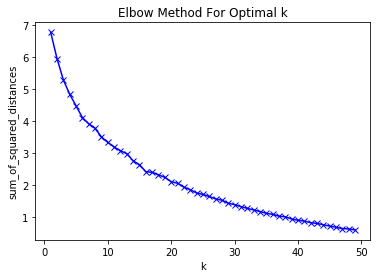

In [51]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [52]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(minneapolis_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(minneapolis_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

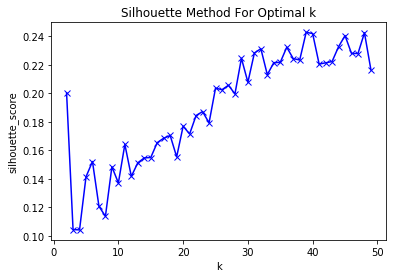

In [53]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [54]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(minneapolis_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({1: 21, 3: 17, 0: 17, 5: 13, 2: 10, 4: 6, 6: 2, 7: 1})


In [55]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [56]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,Armatage,Pizza Place,Italian Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant
1,3,Audubon Park,American Restaurant,Pizza Place,Ice Cream Shop,Latin American Restaurant,Chinese Restaurant
2,3,Bancroft,Vegetarian / Vegan Restaurant,American Restaurant,Ice Cream Shop,Pizza Place,Asian Restaurant
3,0,Beltrami,Middle Eastern Restaurant,American Restaurant,BBQ Joint,Pizza Place,Indian Restaurant
4,1,Bottineau,American Restaurant,Ice Cream Shop,BBQ Joint,Mexican Restaurant,Vietnamese Restaurant


In [57]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
minneapolis_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
minneapolis_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
0,3,Armatage,Pizza Place,Italian Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant,44.905209,-93.317518
1,3,Audubon Park,American Restaurant,Pizza Place,Ice Cream Shop,Latin American Restaurant,Chinese Restaurant,45.023933,-93.242672
2,3,Bancroft,Vegetarian / Vegan Restaurant,American Restaurant,Ice Cream Shop,Pizza Place,Asian Restaurant,44.934145,-93.261240
3,0,Beltrami,Middle Eastern Restaurant,American Restaurant,BBQ Joint,Pizza Place,Indian Restaurant,44.993285,-93.237868
4,1,Bottineau,American Restaurant,Ice Cream Shop,BBQ Joint,Mexican Restaurant,Vietnamese Restaurant,45.005275,-93.263090


In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minneapolis_merged['Latitude'], minneapolis_merged['Longitude'], minneapolis_merged['Neighborhood'], minneapolis_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [59]:
required_column_indices = [2,3,4]
required_column = [list(minneapolis_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,4]

In [60]:
cluster_0 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 0, minneapolis_merged.columns[1:12]]
cluster_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
3,Beltrami,Middle Eastern Restaurant,American Restaurant,BBQ Joint,Pizza Place,Indian Restaurant,44.993285,-93.237868
9,Cedar Riverside,Vietnamese Restaurant,Mexican Restaurant,Fast Food Restaurant,Korean Restaurant,Brewery,44.978485,-93.242757
17,Downtown East,Chinese Restaurant,Brewery,Mexican Restaurant,Japanese Restaurant,Vietnamese Restaurant,44.978934,-93.244986
19,ECCO,American Restaurant,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,44.948367,-93.302114
20,East Harriet,New American Restaurant,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Latin American Restaurant,44.937708,-93.288209
32,Holland,Mexican Restaurant,American Restaurant,Thai Restaurant,Indian Restaurant,Middle Eastern Restaurant,45.016779,-93.249123
39,King Field,Mexican Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Fast Food Restaurant,44.937751,-93.274681
42,Logan Park,Mexican Restaurant,American Restaurant,Thai Restaurant,Vietnamese Restaurant,Sandwich Place,45.007902,-93.249758
47,Lyndale,Fast Food Restaurant,Vietnamese Restaurant,Pizza Place,American Restaurant,Thai Restaurant,44.948358,-93.284292
49,Marcy Holmes,Pizza Place,American Restaurant,Taco Place,BBQ Joint,Indian Restaurant,44.991277,-93.247040


In [61]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Mexican Restaurant               4
Pizza Place                      3
Fast Food Restaurant             2
Vietnamese Restaurant            2
American Restaurant              1
Burger Joint                     1
Chinese Restaurant               1
New American Restaurant          1
Vegetarian / Vegan Restaurant    1
Middle Eastern Restaurant        1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant      6
Mexican Restaurant       2
Pizza Place              2
African Restaurant       2
Thai Restaurant          1
Chinese Restaurant       1
Sandwich Place           1
Vietnamese Restaurant    1
Brewery                  1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Thai Restaurant             3
Taco Place                  2
American Restaurant         2
Chinese Restaurant          1
Mediterranean Restaurant    1
Fast Food Restaurant        1
Sushi Restaurant            1
BBQ Joint            

In [62]:
cluster_1 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 1, minneapolis_merged.columns[1:12]]
cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
4,Bottineau,American Restaurant,Ice Cream Shop,BBQ Joint,Mexican Restaurant,Vietnamese Restaurant,45.005275,-93.263090
6,Bryn - Mawr,American Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Pizza Place,44.980735,-93.314504
11,Cleveland,American Restaurant,Asian Restaurant,BBQ Joint,Mexican Restaurant,Burger Joint,45.024088,-93.308330
16,Diamond Lake,American Restaurant,Italian Restaurant,Asian Restaurant,Burger Joint,Sandwich Place,44.903660,-93.247448
18,Downtown West,American Restaurant,Scandinavian Restaurant,Pizza Place,Burger Joint,Italian Restaurant,44.982995,-93.260106
21,East Isles,American Restaurant,New American Restaurant,Ice Cream Shop,Mexican Restaurant,Steakhouse,44.960917,-93.292727
22,East Phillips,American Restaurant,Pizza Place,Sandwich Place,Vegetarian / Vegan Restaurant,Asian Restaurant,44.960015,-93.246757
23,Elliot Park,American Restaurant,New American Restaurant,Scandinavian Restaurant,Italian Restaurant,Steakhouse,44.975368,-93.262433
29,Harrison,American Restaurant,Southern / Soul Food Restaurant,Brewery,Vegetarian / Vegan Restaurant,Mac & Cheese Joint,44.984367,-93.294015
30,Hawthorne,American Restaurant,BBQ Joint,Ice Cream Shop,German Restaurant,Fast Food Restaurant,45.013137,-93.274484


In [63]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant    21
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                        6
New American Restaurant            5
Mexican Restaurant                 2
Southern / Soul Food Restaurant    2
Italian Restaurant                 1
Ice Cream Shop                     1
Asian Restaurant                   1
Vietnamese Restaurant              1
Scandinavian Restaurant            1
BBQ Joint                          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Ice Cream Shop                   3
Fast Food Restaurant             3
BBQ Joint                        3
Scandinavian Restaurant          2
Asian Restaurant                 2
Steakhouse                       1
Brewery                          1
Burger Joint                     1
Sushi Restaurant                 1
Vegetarian / Vegan Restaurant    1
Vietnamese Restaurant            1
Pizza Place                      1
Sandwich

In [64]:
cluster_2 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 2, minneapolis_merged.columns[1:12]]
cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
13,Como,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Indian Restaurant,Burger Joint,44.993247,-93.229726
43,Longfellow,Fast Food Restaurant,Pizza Place,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,44.954011,-93.236593
52,Mid - City Industrial,African Restaurant,Fast Food Restaurant,Sandwich Place,Donut Shop,Greek Restaurant,44.991713,-93.207558
56,Near - North,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,Sandwich Place,American Restaurant,44.999172,-93.297754
59,Northeast Park,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Chinese Restaurant,Ice Cream Shop,45.006083,-93.217808
62,Phillips West,American Restaurant,African Restaurant,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,44.960908,-93.262581
68,Shingle Creek,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Fried Chicken Joint,Mexican Restaurant,45.051235,-93.310453
77,Ventura Village,Sandwich Place,Fast Food Restaurant,Pizza Place,Brewery,Indian Restaurant,44.966297,-93.249577
84,Willard - Hay,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Chinese Restaurant,American Restaurant,44.999524,-93.298985
86,Windom Park,Sandwich Place,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,45.013248,-93.219565


In [65]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant    6
Sandwich Place          2
American Restaurant     1
African Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place             2
Sandwich Place          2
Fast Food Restaurant    2
Chinese Restaurant      2
African Restaurant      1
Fried Chicken Joint     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Sandwich Place         4
Chinese Restaurant     2
Fried Chicken Joint    1
Mexican Restaurant     1
Pizza Place            1
American Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [66]:
cluster_3 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 3, minneapolis_merged.columns[1:12]]
cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
0,Armatage,Pizza Place,Italian Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant,44.905209,-93.317518
1,Audubon Park,American Restaurant,Pizza Place,Ice Cream Shop,Latin American Restaurant,Chinese Restaurant,45.023933,-93.242672
2,Bancroft,Vegetarian / Vegan Restaurant,American Restaurant,Ice Cream Shop,Pizza Place,Asian Restaurant,44.934145,-93.261240
5,Bryant,American Restaurant,Ice Cream Shop,Southern / Soul Food Restaurant,BBQ Joint,Pizza Place,44.926941,-93.262512
12,Columbia Park,Pizza Place,American Restaurant,Thai Restaurant,Dumpling Restaurant,Chinese Restaurant,45.025677,-93.247348
14,Cooper,Ice Cream Shop,Pizza Place,Burger Joint,Mexican Restaurant,Mediterranean Restaurant,44.953025,-93.207723
24,Ericsson,American Restaurant,Ice Cream Shop,Pizza Place,African Restaurant,Fast Food Restaurant,44.916314,-93.215145
25,Field,Pizza Place,Ice Cream Shop,BBQ Joint,Filipino Restaurant,Donut Shop,44.919707,-93.262592
28,Hale,Pizza Place,Ice Cream Shop,Mexican Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,44.915118,-93.248762
33,Howe,Ice Cream Shop,American Restaurant,Mexican Restaurant,Asian Restaurant,BBQ Joint,44.941552,-93.201042


In [67]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant              6
Pizza Place                      5
Ice Cream Shop                   4
Vegetarian / Vegan Restaurant    1
Burger Joint                     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Ice Cream Shop         7
Pizza Place            4
American Restaurant    3
Mexican Restaurant     1
Chinese Restaurant     1
Italian Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant                 3
Pizza Place                        3
Ice Cream Shop                     2
Southern / Soul Food Restaurant    2
BBQ Joint                          2
Thai Restaurant                    1
Burger Joint                       1
Chinese Restaurant                 1
Italian Restaurant                 1
Sandwich Place                     1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [68]:
cluster_4 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 4, minneapolis_merged.columns[1:12]]
cluster_4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
7,Camden Industrial,BBQ Joint,African Restaurant,Fast Food Restaurant,Ice Cream Shop,Mexican Restaurant,45.042082,-93.280926
26,Folwell,Sandwich Place,African Restaurant,Asian Restaurant,BBQ Joint,Fried Chicken Joint,45.023970,-93.293104
40,Lind - Bohanon,BBQ Joint,African Restaurant,Fast Food Restaurant,Ice Cream Shop,Mexican Restaurant,45.042082,-93.280926
50,Marshall Terrace,BBQ Joint,African Restaurant,Sandwich Place,American Restaurant,Asian Restaurant,45.027614,-93.277919
51,McKinley,African Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Sandwich Place,Fast Food Restaurant,45.023951,-93.290570
80,Webber - Camden,BBQ Joint,American Restaurant,Southern / Soul Food Restaurant,African Restaurant,Sandwich Place,45.037677,-93.299072


In [69]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

BBQ Joint             4
Sandwich Place        1
African Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
African Restaurant     4
American Restaurant    1
BBQ Joint              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant               2
Southern / Soul Food Restaurant    2
Asian Restaurant                   1
Sandwich Place                     1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [70]:
cluster_5 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 5, minneapolis_merged.columns[1:12]]
cluster_5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
8,Cedar - Isles - Dean,American Restaurant,Chinese Restaurant,Sandwich Place,Mexican Restaurant,Noodle House,44.959348,-93.326790
10,Central,Mexican Restaurant,African Restaurant,American Restaurant,Taco Place,Ice Cream Shop,44.941366,-93.262581
15,Corcoran,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,American Restaurant,Latin American Restaurant,44.948370,-93.238170
27,Fulton,Italian Restaurant,Pizza Place,Mexican Restaurant,American Restaurant,Thai Restaurant,44.917891,-93.308746
36,Keewaydin,Mexican Restaurant,Asian Restaurant,Taco Place,BBQ Joint,Steakhouse,44.905375,-93.222875
37,Kenny,Italian Restaurant,Pizza Place,Mexican Restaurant,American Restaurant,Taco Place,44.905117,-93.302295
53,Midtown Phillips,Mexican Restaurant,Chinese Restaurant,African Restaurant,American Restaurant,Taco Place,44.948366,-93.252506
63,Powderhorn Park,Mexican Restaurant,American Restaurant,Chinese Restaurant,Burger Joint,Ice Cream Shop,44.937741,-93.247367
72,Standish,Mexican Restaurant,Ethiopian Restaurant,Asian Restaurant,Pizza Place,American Restaurant,44.930515,-93.226183
75,Tangletown,Pizza Place,Mexican Restaurant,BBQ Joint,American Restaurant,Asian Restaurant,44.909169,-93.274819


In [71]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Mexican Restaurant     8
Italian Restaurant     2
American Restaurant    1
Burger Joint           1
Pizza Place            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      3
American Restaurant     2
Mexican Restaurant      2
Pizza Place             2
Ethiopian Restaurant    1
Asian Restaurant        1
African Restaurant      1
Italian Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant      2
Chinese Restaurant      2
Taco Place              2
BBQ Joint               2
American Restaurant     1
Asian Restaurant        1
African Restaurant      1
Fast Food Restaurant    1
Sandwich Place          1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [72]:
cluster_6 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 6, minneapolis_merged.columns[1:12]]
cluster_6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
34,Humboldt Industrial Area,Fast Food Restaurant,Fried Chicken Joint,Ramen Restaurant,Seafood Restaurant,Falafel Restaurant,45.042178,-93.319386
78,Victory,Fast Food Restaurant,Fried Chicken Joint,Ramen Restaurant,Seafood Restaurant,Falafel Restaurant,45.042016,-93.319382


In [73]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant    2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fried Chicken Joint    2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Ramen Restaurant    2
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [74]:
cluster_7 = minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 7, minneapolis_merged.columns[1:12]]
cluster_7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
31,Hiawatha,Burger Joint,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Empanada Restaurant,44.9307,-93.204951


In [75]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Burger Joint    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
